# Bayse Model 負の二項分布

In [2]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:316: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [3]:
filepath = "../../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath).drop(columns=['special'])
df['log_income'] = np.log(df['income'])
df = df.dropna()

In [4]:
# 過分散パラメータを求める
population = df['population']
mean_population = np.mean(population)
var_population = np.var(population)

alpha = (var_population - mean_population) / mean_population**2


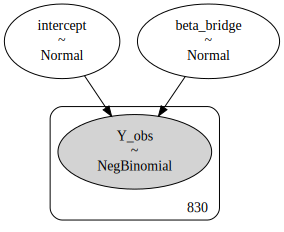

In [8]:
population = df['population'].values
bridge = df['dummy_after_bridge_opened'].values

with pm.Model() as model:
    # 事前分布
    intercept = pm.Normal('intercept', mu=6.6, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=1.7, sigma=100)

    # 対数リンク関数
    lambda_ = pm.math.exp(intercept + beta_bridge * bridge)

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=alpha, observed=population)


# モデルの視覚化
pm.model_to_graphviz(model)

In [6]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [9]:
az.to_netcdf(idata, './bm_negbino_simple.nc')

'./bm_negbino_simple.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,6.647,0.014,6.621,6.672,0.0,0.0,3988.0,4201.0,1.0
beta_bridge,1.775,0.028,1.722,1.827,0.0,0.0,3962.0,4369.0,1.0


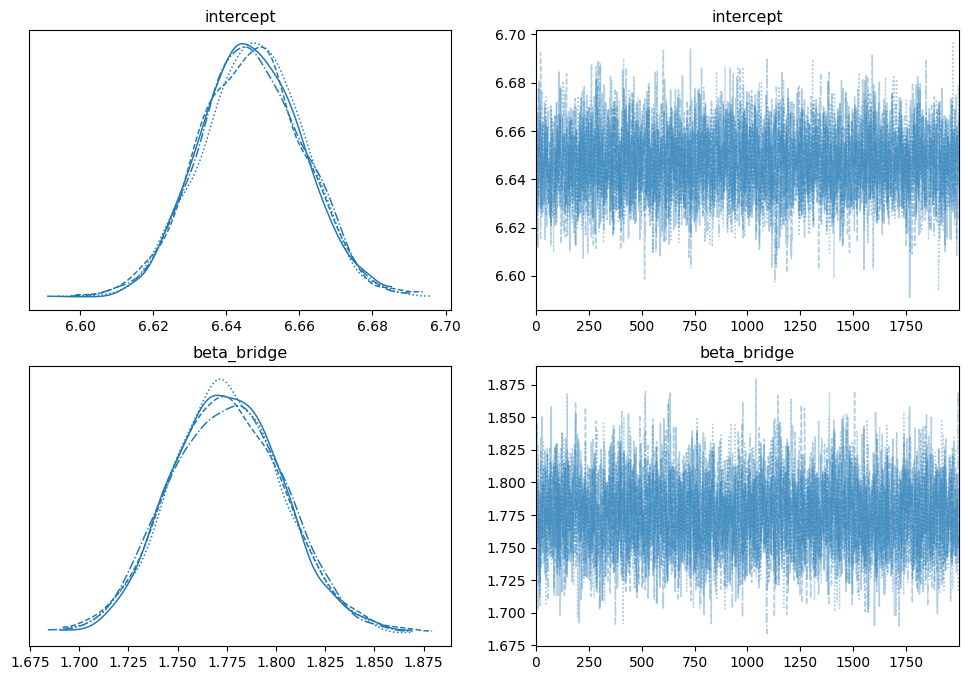

In [10]:
az.plot_trace(idata, figsize=(12, 8))  # サイズを調整
az.summary(idata)

# パラメータが0以上である確率

In [44]:
posterior_samples = idata.posterior

intercept_samples = posterior_samples['intercept']
beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_beta_intercept_positive = np.mean(intercept_samples > 0)
prob_beta_bridge_positive = np.mean(beta_bridge_samples > 0)

print(f"Pr(intercept > 0) = {prob_beta_intercept_positive:.4f}")
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")

P(intercept > 0) = 1.0000
P(beta_bridge > 0) = 1.0000
